#### Crimes Preprocessing

The purpose of this notebook is to download and prepare Chicago crimes data for use with the events dataset.

Please run `events_descriptive_preprocessing.ipynb` first to prepare the necessary shapefiles.

In [24]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import requests
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]  # add more space to figures

In [25]:
events = pd.DataFrame(gpd.read_file('geo/single_day_events.shp').drop(columns=['geometry']))
events

,Name of Ev,Category,Date(s),Location,Estimated,Number Peo,Address,Venue Capa,Venue Type,Latitude,Longitude
0,Alison Wonderland,Music,2018-08-24 00:00:00,Aragon Ballroom,None,4800,"1106 W Lawrence Ave, Chicago, IL 60640",4800.0,Event Space,41.969436,-87.658038
1,"Virtual Self ""Utopia System""",Music,2018-09-07 00:00:00,Aragon Ballroom,None,4800,"1106 W Lawrence Ave, Chicago, IL 60640",4800.0,Event Space,41.969436,-87.658038
2,5 Seconds of Summer / The Aces,Music,2018-09-08 00:00:00,Aragon Ballroom,None,4800,"1106 W Lawrence Ave, Chicago, IL 60640",4800.0,Event Space,41.969436,-87.658038
3,SIGRID W/ HOUSES,Music,2019-08-01 00:00:00,Thalia Hall,Medium,800,"1807 S Allport St, Chicago, IL 60608",800.0,Music,41.857681,-87.657392
4,JUDAH & THE LION W/ THE BAND CAMINO,Music,2019-08-02 00:00:00,Thalia Hall,Medium,800,"1807 S Allport St, Chicago, IL 60608",800.0,Music,41.857681,-87.657392
...,...,...,...,...,...,...,...,...,...,...,...
920,Chicago Cubs vs Los Angeles Dodgers,Sports,2019-03-20 00:00:00,Wrigley Field,Large,41160,"1060 W Addison St, Chicago, IL 60613",41160.0,Sports,41.947588,-87.656125
921,Chicago Cubs vs San Francisco Giants,Sports,2019-03-21 00:00:00,Wrigley Field,Large,41160,"1060 W Addison St, Chicago, IL 60613",41160.0,Sports,41.947588,-87.656125
922,Chicago Cubs vs Los Angeles Angels,Sports,2019-06-03 00:00:00,Wrigley Field,Large,41160,"1060 W Addison St, Chicago, IL 60613",41160.0,Sports,41.947588,-87.656125
923,14TH ANNUAL RACE TO WRIGLEY 5K CHARITY RUN PRE...,Sports,2019-04-27 00:00:00,Wrigley Field,Large,41160,"1060 W Addison St, Chicago, IL 60613",41160.0,Sports,41.947588,-87.656125


In [26]:
events = events.rename(columns={"Date(s)":"Date"})
events["Date"] = pd.to_datetime(events["Date"])

<AxesSubplot:>

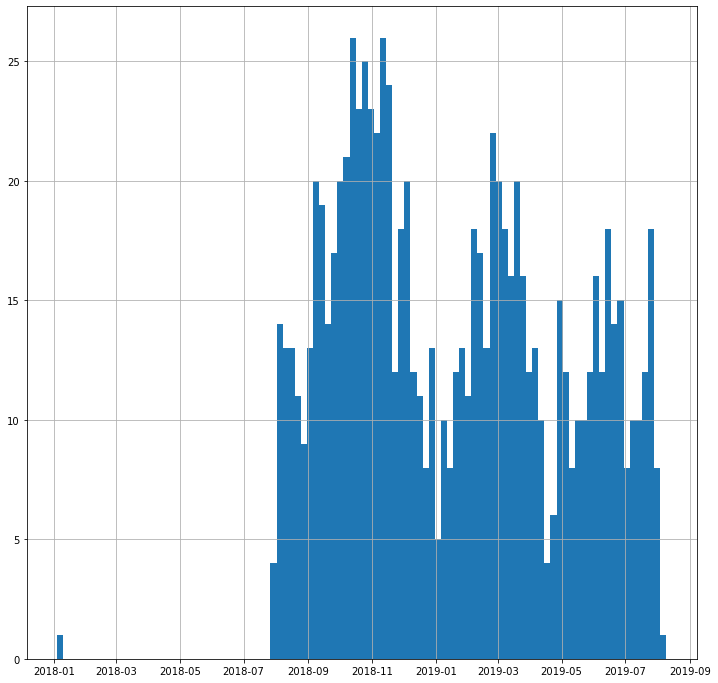

In [27]:
events.Date.hist(bins=100)

That's a bit of an odd pattern... Somewhat concerning in fact. Unclear why there should be so much variation and the peaks/troughs are not where you might expect.

In [28]:
# exclude date outlier

first_date = events.Date.min()
events = events[events.Date != first_date]

In [29]:
print(f'Date range: {events.Date.min()} to {events.Date.max()}')

Date range: 2018-07-28 00:00:00 to 2019-08-09 00:00:00


In [30]:
print(f'Latitude range: {events.Latitude.min()} to {events.Latitude.max()}')
print(f'Longitude range: {events.Longitude.min()} to {events.Longitude.max()}')

Latitude range: 41.790567 to 41.969436
Longitude range: -87.69179 to -87.58305


How long is a kilometer in terms of latitude or longitude? For longitude, this depends on the latitude! But we will use a single conversion within the bounds of Chicago, since it's a relatively small geographic area. Note that this will have the effect of making idealized-circular bandwidths "squashed" (slightly elliptical).

In [31]:
# To do this calculation we'll also assume the Earth is perfectly spherical.

EARTH_RADIUS = 6371  # in km

radians_per_degree = math.pi / 180
earth_circumference = 2 * math.pi * EARTH_RADIUS  # in km
degree_latitude_in_km = 1 * radians_per_degree * earth_circumference / (2 * math.pi)  # 1 degree in radians * distance per radian
degree_latitude_in_km

111.19492664455873

In [32]:
CHICAGO_LATITUDE = 41.8781  # in degrees

great_circle_radius_at_chicago = EARTH_RADIUS * math.cos(CHICAGO_LATITUDE * radians_per_degree)  # in km
great_circle_circumference = 2 * math.pi * great_circle_radius_at_chicago  # in km
degree_longitude_in_km = 1 * radians_per_degree * great_circle_circumference / (2 * math.pi)  # 1 degree in radians * distance per radian
degree_longitude_in_km

82.79204576635829

In [33]:
# calculate 1 km buffer distance
lat_buffer = 1 / degree_latitude_in_km
lon_buffer = 1 / degree_longitude_in_km

In [34]:
# construct crimes API request for data with one-day buffer on each side
# per: https://dev.socrata.com/docs/datatypes/floating_timestamp.html#2.1,

APP_TOKEN = "9AZUQHKIvfHKueRPyPpwmmZcp"  # for drewkeller@uchicago.edu
DATASET_URL = "https://data.cityofchicago.org/resource/6zsd-86xi.json"
date_filter = "?$where=date between '2018-07-27T00:00:00' and '2019-08-11T00:00:00'"
latitude_filter = f" AND latitude between {events.Latitude.min()-lat_buffer} and {events.Latitude.max()+lat_buffer}"
longitude_filter = f" AND longitude between {events.Longitude.min()-lon_buffer} and {events.Longitude.max()+lon_buffer}"
token = f"&$$app_token={APP_TOKEN}"

try:
    offset = 0
    data_list = []
    while True:
        paging = f"&$order=date&$limit=50000&$offset={offset}"
        request = DATASET_URL + date_filter + latitude_filter + longitude_filter + paging + token
        response = requests.get(request)
        response = response.json()
        print("Another 50,000 fetched.")
        offset += 50000  # advances to the next page
        data_list += response
        if len(response)<49999:
            break
except:
    print(f"\nThe API call failed and provided the following reason: {response.text}\n")
    raise Exception(response)

crimes = pd.DataFrame(data_list)
crimes

Another 50,000 fetched.
Another 50,000 fetched.
Another 50,000 fetched.


,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,y_coordinate,year,updated_on,latitude,longitude,location,location_address,location_city,location_state,location_zip
0,11393720,JB367241,2018-07-27T00:00:00.000,047XX N BROADWAY,1305,CRIMINAL DAMAGE,CRIMINAL DEFACEMENT,BANK,False,False,...,1931512,2018,2018-08-03T16:16:20.000,41.967618619,-87.658896113,"{'type': 'Point', 'coordinates': [-87.65889611...",,,,
1,11394961,JB368503,2018-07-27T00:00:00.000,001XX W HUBBARD ST,0870,THEFT,POCKET-PICKING,TAVERN/LIQUOR STORE,False,False,...,1903292,2018,2018-08-03T16:16:20.000,41.890013771,-87.631705393,"{'type': 'Point', 'coordinates': [-87.63170539...",,,,
2,11480254,JB480430,2018-07-27T00:00:00.000,012XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,1894900,2018,2018-10-25T16:10:05.000,41.866937617,-87.624141504,"{'type': 'Point', 'coordinates': [-87.62414150...",,,,
3,11395054,JB368869,2018-07-27T00:01:00.000,040XX N BROADWAY,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,1926986,2018,2018-08-03T16:16:20.000,41.955151216,-87.650921125,"{'type': 'Point', 'coordinates': [-87.65092112...",,,,
4,11395057,JB368870,2018-07-27T00:01:00.000,040XX N BROADWAY,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,APARTMENT,False,False,...,1926986,2018,2018-08-03T16:16:20.000,41.955151216,-87.650921125,"{'type': 'Point', 'coordinates': [-87.65092112...",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103490,11790084,JC387494,2019-08-10T23:45:00.000,001XX S HALSTED ST,0870,THEFT,POCKET-PICKING,BAR OR TAVERN,False,False,...,1899605,2019,2019-08-17T16:05:51.000,41.879990018,-87.647307571,"{'type': 'Point', 'coordinates': [-87.64730757...",,,,
103491,11790431,JC387911,2019-08-10T23:59:00.000,040XX S FEDERAL ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,True,...,1878227,2019,2019-08-17T16:05:51.000,41.82120971,-87.628549833,"{'type': 'Point', 'coordinates': [-87.62854983...",,,,
103492,11790428,JC387941,2019-08-11T00:00:00.000,031XX N SHEFFIELD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,...,1920952,2019,2019-08-18T16:11:00.000,41.938611249,-87.654059908,"{'type': 'Point', 'coordinates': [-87.65405990...",,,,
103493,11791865,JC389527,2019-08-11T00:00:00.000,009XX W BELMONT AVE,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,1921430,2019,2019-08-18T16:11:00.000,41.939918899,-87.653369734,"{'type': 'Point', 'coordinates': [-87.65336973...",,,,


In [35]:
crimes.columns

Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location', 'location_address', 'location_city', 'location_state',
       'location_zip'],
      dtype='object')

In [36]:
# convert date to datetime, latitude and longitude to float
crimes["date"] = pd.to_datetime(crimes["date"])
crimes["latitude"] = pd.to_numeric(crimes["latitude"])
crimes["longitude"] = pd.to_numeric(crimes["longitude"])

<AxesSubplot:>

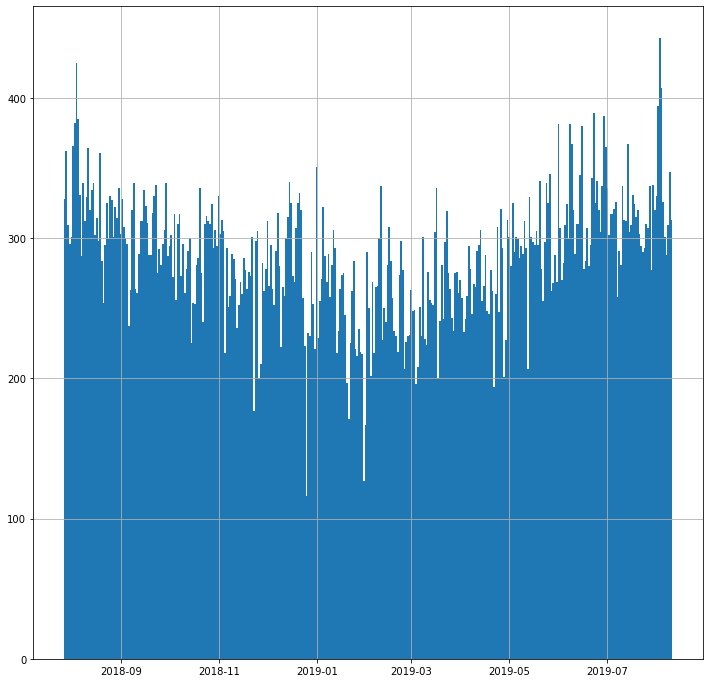

In [37]:
crimes.date.hist(bins=360)

Now we need to link crimes to venues. We will create a column of the crimes dataset for each venue from the 'Location' column of the events dataset, with 1 if the crime is within a 1km buffer of the venue, else 0. 

In [38]:
locations = list(set(events.Location))
for location in locations:
    latitude = events.Latitude[events.Location == location].mean()
    longitude = events.Longitude[events.Location == location].mean()
    crimes[location] = np.where(  # this is a square buffer
        crimes.latitude.between(latitude-lat_buffer, latitude+lat_buffer) & 
        crimes.longitude.between(longitude-lon_buffer, longitude+lon_buffer), 
        1,0)
    #crimes[location] = np.where(  # this is a circular buffer
    #    (crimes.latitude-latitude)**2+(crimes.longitude-longitude)**2<np.mean(lat_buffer+lon_buffer),
    #    1,0)
    # the ideal would be an elliptical buffer with axes based on lat_buffer and lon_buffer
crimes.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,The Chicago Theatre,Gallagher Way,Aragon Ballroom,Arie Crown Theater,Credit Union 1 Arena,Union Station,Grant Park,Concord Music Hall,Wrigley Field,Millennium Park
0,11393720,JB367241,2018-07-27 00:00:00,047XX N BROADWAY,1305,CRIMINAL DAMAGE,CRIMINAL DEFACEMENT,BANK,False,False,...,0,0,1,0,0,0,0,0,0,0
1,11394961,JB368503,2018-07-27 00:00:00,001XX W HUBBARD ST,0870,THEFT,POCKET-PICKING,TAVERN/LIQUOR STORE,False,False,...,1,0,0,0,0,0,0,0,0,1
2,11480254,JB480430,2018-07-27 00:00:00,012XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,0,0,0,0,0,0,1,0,0,0
3,11395054,JB368869,2018-07-27 00:01:00,040XX N BROADWAY,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,0,1,0,0,0,0,0,0,1,0
4,11395057,JB368870,2018-07-27 00:01:00,040XX N BROADWAY,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,APARTMENT,False,False,...,0,1,0,0,0,0,0,0,1,0


In [39]:
crimes["near_any_venue"] = crimes[locations].any(1).astype(int)
crimes.near_any_venue.value_counts()

0    55298
1    48197
Name: near_any_venue, dtype: int64

In [40]:
for location in set(events.Location):
    print(f'{location}: {crimes[location].sum()}')

Auditorium Theatre: 9254
Main Hall in UIC Dorin Forum: 2141
Guaranteed Rate Field: 1659
Soldier Field: 3225
Petrillo Music Shell: 8899
Huntington Bank Pavilion: 140
Riviera Theatre: 3358
Museum of Science and Industry: 1210
Field Museum: 2001
Civic Opera House: 11924
Lincoln Park Zoo: 1479
Cinespace Chicago Film Studios: 2413
Thalia Hall: 1876
United Center: 2653
Sheraton Grand Chicago: 12493
Chicago Symphony Orchestra: 10569
The Chicago Theatre: 14683
Gallagher Way: 3846
Aragon Ballroom: 3332
Arie Crown Theater: 2099
Credit Union 1 Arena: 2509
Union Station: 6169
Grant Park: 4077
Concord Music Hall: 2502
Wrigley Field: 3973
Millennium Park: 12159


Now we'll create events columns in the crimes dataset to track treatment intensity. For each crime's venues, check if there were any events on the same day. Add one to the `event_day` column for each. This means that if a crime was within the bandwidth of two venues that had events, its treatment intensity is 2.

Then construct indicators for different times.
- If the crime was between 6pm - 12am, `evening_crime` = 1, else 0
- Etc for sliding windows

Then we will construct treatment indicators for different time bandwidths.

- If the crime was between 6pm - 12am, `event_evening_crimes` = `event_day_crimes`.
- Then create treatment columns for sliding window of times like `event_3pm-6pm_crimes` = `event_day_crimes` iff crime was between 3 and 6 pm, etc. 


In [41]:
# first calculate `day_crimes`
crimes["event_day"] = 0
for index,event in events.iterrows():
    crimes["event_day"][(crimes[event.Location]==1) & (event.Date.date()==crimes.date.dt.date)] += 1
crimes.head()

/project/graziul/ra/drewkeller/geoconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/project/graziul/ra/drewkeller/geoconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/project/graziul/ra/drewkeller/geoconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,Aragon Ballroom,Arie Crown Theater,Credit Union 1 Arena,Union Station,Grant Park,Concord Music Hall,Wrigley Field,Millennium Park,near_any_venue,event_day
0,11393720,JB367241,2018-07-27 00:00:00,047XX N BROADWAY,1305,CRIMINAL DAMAGE,CRIMINAL DEFACEMENT,BANK,False,False,...,1,0,0,0,0,0,0,0,1,0
1,11394961,JB368503,2018-07-27 00:00:00,001XX W HUBBARD ST,0870,THEFT,POCKET-PICKING,TAVERN/LIQUOR STORE,False,False,...,0,0,0,0,0,0,0,1,1,0
2,11480254,JB480430,2018-07-27 00:00:00,012XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,0,0,0,0,1,0,0,0,1,0
3,11395054,JB368869,2018-07-27 00:01:00,040XX N BROADWAY,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,0,0,0,0,0,0,1,0,1,0
4,11395057,JB368870,2018-07-27 00:01:00,040XX N BROADWAY,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,APARTMENT,False,False,...,0,0,0,0,0,0,1,0,1,0


In [43]:
crimes.event_day.value_counts()

0    93765
1     8247
2     1267
3      196
4       20
Name: event_day, dtype: int64

In [45]:
# now calculate within time bandwidths

crimes["evening_crime"] = np.where(
    crimes.date.dt.hour.between(18,24),
    1, 0
)

crimes["3to6_crime"] = np.where(
    crimes.date.dt.hour.between(15,18),
    1, 0
)

crimes["4to7_crime"] = np.where(
    crimes.date.dt.hour.between(16,19),
    1, 0
)

crimes["5to8_crime"] = np.where(
    crimes.date.dt.hour.between(17,20),
    1, 0
)

crimes["6to9_crime"] = np.where(
    crimes.date.dt.hour.between(18,21),
    1, 0
)

crimes["7to10_crime"] = np.where(
    crimes.date.dt.hour.between(19,22),
    1, 0
)

crimes["8to11_crime"] = np.where(
    crimes.date.dt.hour.between(20,23),
    1, 0
)

crimes["9to12_crime"] = np.where(
    crimes.date.dt.hour.between(21,24),
    1, 0
)

crimes["event_evening_crimes"] = np.where(
    crimes.date.dt.hour.between(18,24),
    crimes.event_day,
    0)
print(f'Number of evening crimes: {sum(crimes.evening_crime)}')
print(f'Number of evening crimes on days with events: {sum(crimes.event_evening)}')
crimes["event_3to6"] = np.where(
    crimes.date.dt.hour.between(15,18),
    crimes.event_day,
    0)
print(f'Number of 3pm-6pm crimes: {sum(crimes["3to6_crime"])}')
print(f'Number of 3pm-6pm crimes on days with events: {sum(crimes["event_3to6"])}')
crimes["event_4to7"] = np.where(
    crimes.date.dt.hour.between(16,19),
    crimes.event_day,
    0)
print(f'Number of 4pm-7pm crimes: {sum(crimes["4to7_crime"])}')
print(f'Number of 4pm-7pm crimes on days with events: {sum(crimes["event_4to7"])}')
crimes["event_5to8"] = np.where(
    crimes.date.dt.hour.between(17,20),
    crimes.event_day,
    0)
print(f'Number of 5pm-8pm crimes: {sum(crimes["5to8_crime"])}')
print(f'Number of 5pm-8pm crimes on days with events: {sum(crimes["event_5to8"])}')
crimes["event_6to9"] = np.where(
    crimes.date.dt.hour.between(18,21),
    crimes.event_day,
    0)
print(f'Number of 6pm-9pm crimes: {sum(crimes["6to9_crime"])}')
print(f'Number of 6pm-9pm crimes on days with events: {sum(crimes["event_6to9"])}')
crimes["event_7to10"] = np.where(
    crimes.date.dt.hour.between(19,22),
    crimes.event_day,
    0)
print(f'Number of 7pm-10pm crimes: {sum(crimes["7to10_crime"])}')
print(f'Number of 7pm-10pm crimes on days with events: {sum(crimes["event_7to10"])}')
crimes["event_8to11"] = np.where(
    crimes.date.dt.hour.between(20,23),
    crimes.event_day,
    0)
print(f'Number of 8pm-11pm crimes: {sum(crimes["8to11_crime"])}')
print(f'Number of 8pm-11pm crimes on days with events: {sum(crimes["event_8to11"])}')
crimes["event_9to12"] = np.where(
    crimes.date.dt.hour.between(21,24),
    crimes.event_day,
    0)
print(f'Number of 9pm-12am crimes: {sum(crimes["9to12_crime"])}')
print(f'Number of 9pm-12am crimes on days with events: {sum(crimes["event_9to12"])}')

Number of evening crimes: 30685
Number of evening crimes on days with events: 3203
Number of 3pm-6pm crimes: 24452
Number of 3pm-6pm crimes on days with events: 2907
Number of 4pm-7pm crimes: 24349
Number of 4pm-7pm crimes on days with events: 2801
Number of 5pm-8pm crimes: 23785
Number of 5pm-8pm crimes on days with events: 2622
Number of 6pm-9pm crimes: 22335
Number of 6pm-9pm crimes on days with events: 2376
Number of 7pm-10pm crimes: 20667
Number of 7pm-10pm crimes on days with events: 2126
Number of 8pm-11pm crimes: 18416
Number of 8pm-11pm crimes on days with events: 1848
Number of 9pm-12am crimes: 13057
Number of 9pm-12am crimes on days with events: 1285


In [46]:
crimes.to_csv('data/crime_event_treated.csv')

In [47]:
crimes.columns

Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location', 'location_address', 'location_city', 'location_state',
       'location_zip', 'Auditorium Theatre', 'Main Hall in UIC Dorin Forum',
       'Guaranteed Rate Field', 'Soldier Field', 'Petrillo Music Shell',
       'Huntington Bank Pavilion', 'Riviera Theatre',
       'Museum of Science and Industry', 'Field Museum', 'Civic Opera House',
       'Lincoln Park Zoo', 'Cinespace Chicago Film Studios', 'Thalia Hall',
       'United Center', 'Sheraton Grand Chicago', 'Chicago Symphony Orchestra',
       'The Chicago Theatre', 'Gallagher Way', 'Aragon Ballroom',
       'Arie Crown Theater', 'Credit Union 1 Arena', 'Union Station',
       'Grant Park', 'Concord Music Hall', 'Wrigley Field', 'Mil

To summarize, the dataframe includes:

- Spatial proximity: dummy variables with the name of each venue which are 1 if the crime was within the venue's bandwidth, else 0
- Temporal proximity: dummy variables named "day_crime", "evening_crime", "3to6_crime", etc. to indicate if the crime happened in a certain time period
- Treatment intensity: variables named "event_day_crimes","event_evening_crimes","event_3to6_crimes", etc. to indicate the number of events within bandwidth for crimes at different times.